 # AEA1 - Final Project

### Doruk Sirtioglu - 2003898

## Introduction

In this project, we replicate the the predictive model in Section 2C of the paper **"Stories of the Twentieth Century for the Twenty First", by Gourinchas and Obstfield (2011)**. The model uses logistic regression as a workhorse model to predict several types of crises through specific macroeconomic indicators. We use the abridged dataset that is consisted of the publicly available data sources, which are indicated in the paper. 

In [635]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## Import Libraries

<a id="importlib"></a>

In [636]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Insert and define data

In [637]:
df = pd.read_csv("Python_Data_Final.csv")
df.head

<bound method NDFrame.head of       currcrisisvar1  currcrisisvar2  currcrisisvar3  currcrisisvar4  \
0                  0               0               1               0   
1                  0               1               0               0   
2                  1               0               0               0   
3                  0               0               0               0   
4                  0               0               0               0   
5                  0               0               0               0   
6                  0               0               0               1   
7                  0               0               1               0   
8                  0               1               0               1   
9                  1               0               1               0   
10                 0               1               0               0   
11                 1               0               0               0   
12                 0              

In [638]:
number_of_obs = df['country'].count()
count_country = df['country'].nunique()
max_date = df['date'].max()
min_date = df['date'].min()

print("Dataset consists of " + '\033[1m' + str(number_of_obs) + '\033[0m' + " panel data \
observations from "+ '\033[1m' + str(count_country) + " countries " + '\033[0m' + " from " + '\033[1m' + str(min_date) \
+ " until " + '\033[1m' + str(max_date) + '\033[0m'+". The countries are dichotomized as advanced \
or emerging, indicated with the binary column 'high'. By running the analyses \
on two separate groups, Gourinchas and Obstfield aims to compare features and\
drivers in advanced and developing economies. The authors restrict their scope\
to three types of crisis, which are: currency crises (where the exchange rate \
falls to speculative pressure), banking crises (where banks struggle to stay \
solvent in a systemic trend), and government default crises (also referred to \
as sovereign debt crises). They include the global financial crisis of 2008 as \
the fourth crisis type since it has affected both types of economies globally.")


Dataset consists of 3002 panel data observations from 79 countries  from 1973 until 2010. The countries are dichotomized as advanced or emerging, indicated with the binary column 'high'. By running the analyses on two separate groups, Gourinchas and Obstfield aims to compare features anddrivers in advanced and developing economies. The authors restrict their scopeto three types of crisis, which are: currency crises (where the exchange rate falls to speculative pressure), banking crises (where banks struggle to stay solvent in a systemic trend), and government default crises (also referred to as sovereign debt crises). They include the global financial crisis of 2008 as the fourth crisis type since it has affected both types of economies globally.


## Data Cleaning

<a id="datacleaning"></a>

In [639]:
df.rename(columns=df.iloc[0])

df.rename(
  columns={
    "variable1" : 'OutGap',
    "variable2" : 'Credit/Gdp',
    "variable3" : "ExtLeverage",
    "variable4" : "CA/Gdp", 
    "variable5" : "Reserves/Gdp",
    "variable6" : "ExchangeRate",
    "variable7" : "ExtShortTDebt/Gdp",
    "variable8" : "PubDebt/Gdp", 
    "variable9" : "Inflation",
    "variable10": "RealInterest"
  },
  inplace=True
)

df = df.dropna(subset=['OutGap'])
df = df.dropna(subset=['Credit/Gdp'])
df = df.dropna(subset=['CA/Gdp'])
df = df.dropna(subset=['Reserves/Gdp'])
df = df.dropna(subset=['ExchangeRate'])
df = df.dropna(subset=['ExtShortTDebt/Gdp'])
df = df.dropna(subset=['PubDebt/Gdp'])                             

In [640]:
#Ordering columns according to their relevance
df_clean = df[['high', 'country', 'date', 'crisis', 'OutGap', 'Credit/Gdp', 'ExtLeverage', 'CA/Gdp','Reserves/Gdp',\
         'ExchangeRate', 'ExtShortTDebt/Gdp', 'PubDebt/Gdp','Inflation','RealInterest',\
         'isocode', 'imfcode','observation', 
         'groupid','id', 'names', 'currcrisisvar1', 'currcrisisvar2', 'currcrisisvar3',\
         'currcrisisvar4','currcrisisvar5', 'currcrisisvarL0', 'currcrisisvarL1',\
         'currcrisisvarL2', 'currcrisisvarL3', 'currcrisisvarL4', 'currcrisisvarL5',\
        'crisisd2008', 'crisis2008var5','crisis2008var4',\
       'crisis2008var3', 'crisis2008var2', 'crisis2008var1', 'crisis2008varL0',\
       'crisis2008varL1', 'crisis2008varL2', 'crisis2008varL3',\
       'crisis2008varL4', 'crisis2008varL5', 'bankvar1', 'bankvar2',\
       'bankvar3', 'bankvar4', 'bankvar5', 'bankvarL0', 'bankvarL1',\
       'bankvarL2', 'bankvarL3', 'bankvarL4', 'bankvarL5', 'defaultvarL0',\
       'defaultvarL1', 'defaultvarL2', 'defaultvarL3', 'defaultvarL4',\
       'defaultvarL5', 'defaultvar1', 'defaultvar2', 'defaultvar3',\
       'defaultvar4', 'defaultvar5']]

This study replicates the estimation model of the paper. The authors segregate the countries as advanced and emerging market economies since the have different market dynamics and marcoeconomic drivers. In out study, we limit the scope to emerging market economies for the sake of not repeating the same procedure two times. However, we will take the research one step further by utilizing the capabilities of Python, and extend the model by running a machine learning algorithm to explore whether there is a contagion between currency and banking crises.

# Estimating Crises

<a id="replication"></a>

In [641]:
#Create dataframe with the emerging market economies (high=0)

#Emerging Market Economies:
df_eme = df_clean[df_clean['high'] == 0]
df_adv = df_clean[df_clean['high'] == 1]

## Sovereign Debt Crises:

<a id="sovdebt"></a>

In [642]:
#Currency crisis prediction for Emerging Market Economies in the next year
regressor_vars = ['OutGap', 'Credit/Gdp', 'CA/Gdp', 'Reserves/Gdp', \
                'ExchangeRate', 'ExtShortTDebt/Gdp', 'PubDebt/Gdp']

logit_sov = sm.Logit(df_eme['defaultvar1'], df_eme[regressor_vars], missing='drop')

result_sov = logit_sov.fit()

print(result_sov.summary())

Optimization terminated successfully.
         Current function value: 0.209782
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            defaultvar1   No. Observations:                  851
Model:                          Logit   Df Residuals:                      844
Method:                           MLE   Df Model:                            6
Date:                Thu, 17 Jan 2019   Pseudo R-squ.:                0.002386
Time:                        22:18:44   Log-Likelihood:                -178.52
converged:                       True   LL-Null:                       -178.95
                                        LLR p-value:                    0.9905
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OutGap                0.0172      0.033      0.522      0.602      -0.047       0.082
Credit/G

In [643]:
margeff_sov = result_sov.get_margeff(at='mean', method='dydx')
print(margeff_sov.summary())

        Logit Marginal Effects       
Dep. Variable:            defaultvar1
Method:                          dydx
At:                              mean
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OutGap                0.0004      0.001      0.524      0.600      -0.001       0.002
Credit/Gdp            0.0011      0.000      3.076      0.002       0.000       0.002
CA/Gdp                0.0031      0.001      3.193      0.001       0.001       0.005
Reserves/Gdp         -0.0063      0.001     -6.306      0.000      -0.008      -0.004
ExchangeRate         -0.0003      0.000     -1.756      0.079      -0.001    2.98e-05
ExtShortTDebt/Gdp -5.031e-05      0.001     -0.082      0.935      -0.001       0.001
PubDebt/Gdp          -0.0005      0.000     -2.587      0.010      -0.001      -0.000


## Banking Crises:

<a id="banking"></a>

In [644]:
#Currency crisis prediction for Emerging Market Economies in the next year
regressor_vars = ['OutGap', 'Credit/Gdp', 'CA/Gdp', 'Reserves/Gdp', \
                'ExchangeRate', 'ExtShortTDebt/Gdp', 'PubDebt/Gdp']

logit_bank = sm.Logit(df_eme['bankvar1'], df_eme[regressor_vars], missing='drop')

result_bank = logit_bank.fit()

print(result_bank.summary())

Optimization terminated successfully.
         Current function value: 0.186008
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               bankvar1   No. Observations:                  851
Model:                          Logit   Df Residuals:                      844
Method:                           MLE   Df Model:                            6
Date:                Thu, 17 Jan 2019   Pseudo R-squ.:               0.0001932
Time:                        22:18:44   Log-Likelihood:                -158.29
converged:                       True   LL-Null:                       -158.32
                                        LLR p-value:                     1.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OutGap                0.0769      0.037      2.090      0.037       0.005       0.149
Credit/G

In [645]:
mareff_bank = result_bank.get_margeff(at='mean', method='dydx')
print(mareff_bank.summary())

        Logit Marginal Effects       
Dep. Variable:               bankvar1
Method:                          dydx
At:                              mean
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OutGap                0.0016      0.001      2.047      0.041    6.98e-05       0.003
Credit/Gdp            0.0013      0.000      3.786      0.000       0.001       0.002
CA/Gdp                0.0015      0.001      1.846      0.065   -9.45e-05       0.003
Reserves/Gdp         -0.0039      0.001     -4.749      0.000      -0.006      -0.002
ExchangeRate         -0.0004      0.000     -2.679      0.007      -0.001   -9.68e-05
ExtShortTDebt/Gdp    -0.0009      0.001     -1.322      0.186      -0.002       0.000
PubDebt/Gdp          -0.0006      0.000     -3.530      0.000      -0.001      -0.000


## Currency Crises

<a id="currency"></a>

In [646]:
#Currency crisis prediction for Emerging Market Economies in the next year
regressor_vars = ['OutGap', 'Credit/Gdp', 'CA/Gdp', 'Reserves/Gdp', \
                'ExchangeRate', 'ExtShortTDebt/Gdp', 'PubDebt/Gdp']

logit_curr = sm.Logit(df_eme['currcrisisvar1'], df_eme[regressor_vars], missing='drop')

result_currency = logit_curr.fit()

print(result_currency.summary())

Optimization terminated successfully.
         Current function value: 0.233619
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         currcrisisvar1   No. Observations:                  851
Model:                          Logit   Df Residuals:                      844
Method:                           MLE   Df Model:                            6
Date:                Thu, 17 Jan 2019   Pseudo R-squ.:                 0.04939
Time:                        22:18:44   Log-Likelihood:                -198.81
converged:                       True   LL-Null:                       -209.14
                                        LLR p-value:                  0.002113
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OutGap                0.0895      0.033      2.708      0.007       0.025       0.154
Credit/G

In [647]:
margeff_currency = result_currency.get_margeff(at='mean', method='dydx')
print(margeff_currency.summary())

        Logit Marginal Effects       
Dep. Variable:         currcrisisvar1
Method:                          dydx
At:                              mean
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
OutGap                0.0030      0.001      2.617      0.009       0.001       0.005
Credit/Gdp            0.0009      0.000      2.084      0.037    5.09e-05       0.002
CA/Gdp                0.0004      0.001      0.353      0.724      -0.002       0.003
Reserves/Gdp         -0.0063      0.001     -6.191      0.000      -0.008      -0.004
ExchangeRate         -0.0003      0.000     -1.928      0.054      -0.001    5.74e-06
ExtShortTDebt/Gdp    -0.0003      0.001     -0.433      0.665      -0.002       0.001
PubDebt/Gdp          -0.0009      0.000     -3.765      0.000      -0.001      -0.000


## Interpretation of the Results

<a id="interpretation"></a>

We run three regressions to estimate the effects of given macroeconomic indicators on the occurence of soveregin debt, banking and currency crises. To have sound interpretation of the results, we look at the marginal effects of the significant variables, which we observe them at the mean values for each variable, following the authors. We obtain similar marginal results with them. Across all types of crises, four variables play a significant role: 
+ Ratio of domestic credit to output,
+ The ratio of official reserves, 
+ The real exchange rate, 
+ The ratio of public debt to output.

Each significant variable is interpreted below.

### Ratio of domestic credit to output: 

An increase in domestic credit above trend significantly increases the chances of a currency crisis within next year year (at 5% level). The marginal effect of an increase in domestic credit is largest on banking crises, with 0.13%, meaning one standard deviation change increases the probability of a currency crisis in the next year by 0.13%, at the mean value.

### The ratio of official reserves:

Having higher foreign exchange ratate reserves reduces the probability of a crises in the following year, where the effect if largest for soveregin debt and currency crises with 0.63%, one percentage point increase in reserve to output ratio decreases the the probability of a debt or currency crises by 0.63% for the next year.

### The real exchange rate:

A one-standard deviation depreciation of the real exchange rate reduces the probability of sovereign default by 0.03 percent, of banking crisis by 0.04 percent, and of currency crisis by 0.03 percent.


### The ratio of public debt to output:

Surprisingly, higher levels of public debt predict a decreased chance of 
banking and currency crises, decreasing the chances by 0.06 percent and 0.05 percent, respectively, at the mean values. However, higher public debt levels indicate a higher risk of sovereign default for the following year.

# Visualization

<a id="visualization"></a>

We replicate the visuals similar to Figures 1 to 6 in the paper. For the sake of conciseness, we visualize the predictions only for the significant variables for emerging market economies. 

In [648]:
#Estimation the significant covariates relative to tranquil times (based on Equation 1 in the paper)

predictors = ['defaultvarL5', 'defaultvarL4', 'defaultvarL3', 'defaultvarL2','defaultvarL1', 
'defaultvarL0','defaultvar1', 'defaultvar2', 'defaultvar3','defaultvar4', 'defaultvar5', 
'bankvarL5', 'bankvarL4', 'bankvarL3', 'bankvarL2', 'bankvarL1', 'bankvarL0', 'bankvar1', 'bankvar2',
'bankvar3', 'bankvar4', 'bankvar5',    
'currcrisisvarL5','currcrisisvarL4','currcrisisvarL3', 'currcrisisvarL2', 'currcrisisvarL1',
'currcrisisvarL0', 'currcrisisvar1', 'currcrisisvar2', 'currcrisisvar3', 'currcrisisvar4',
'currcrisisvar5', 
'crisis2008varL5', 'crisis2008varL4', 'crisis2008varL3', 'crisis2008varL2', 
'crisis2008varL1', 'crisis2008varL0', 'crisis2008var1', 'crisis2008var2',
'crisis2008var3', 'crisis2008var4', 'crisis2008var5']

In [649]:
#Credit/Gdp estimation
CreditGdp_Est = sm.OLS(df_eme['Credit/Gdp'], df_eme[predictors], missing='drop')
res_CreditGdp_Est = CreditGdp_Est.fit()
CreditGdp = res_CreditGdp_Est.params
CreditGdp_Eme = np.array(res_CreditGdp_Est.conf_int(alpha=0.05, cols=None))
#print(res_OutGap_Est.summary())

#Reserves/Gdp estimation
Reserves_Est = sm.OLS(df_eme['Reserves/Gdp'], df_eme[predictors], missing='drop')
res_Reserves_Est = Reserves_Est.fit()
Reserves = res_Reserves_Est.params
Reserves_Eme = np.array(res_Reserves_Est.conf_int(alpha=0.05, cols=None))

#Exchange Rate estimation
Exchange_Est = sm.OLS(df_eme['ExchangeRate'], df_eme[predictors], missing='drop')
res_Exchange_Est = Exchange_Est.fit()
Exchange = res_Exchange_Est.params
Exchange_Eme = np.array(res_Exchange_Est.conf_int(alpha=0.05, cols=None))

#Output Gap estimation
PubDebt_Est = sm.OLS(df_eme['PubDebt/Gdp'], df_eme[predictors], missing='drop')
res_PubDebt_Est = PubDebt_Est.fit()
PubDebt = res_PubDebt_Est.params
PubDebt_Eme = np.array(res_PubDebt_Est.conf_int(alpha=0.05, cols=None))

In [650]:
Eventtime = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5,
             -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5,
             -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5,
             -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5] 

Crisis = ['Default', 'Default', 'Default', 'Default', 'Default',
          'Default', 'Default', 'Default', 'Default', 'Default', 'Default',
          'Banking', 'Banking', 'Banking', 'Banking', 'Banking',
          'Banking', 'Banking', 'Banking', 'Banking', 'Banking', 'Banking',
          'Currency', 'Currency', 'Currency', 'Currency', 'Currency',
          'Currency', 'Currency', 'Currency', 'Currency', 'Currency', 'Currency',
          '2008', '2008', '2008', '2008', '2008',
          '2008', '2008', '2008', '2008', '2008', '2008']

In [651]:
zipped = list(zip(predictors, Crisis, Eventtime, 
                  CreditGdp, CreditGdp_Eme[:,0], CreditGdp_Eme[:,1],
                  Reserves, Reserves_Eme[:,0], Reserves_Eme[:,1],
                  Exchange, Exchange_Eme[:,0], Exchange_Eme[:,1],
                  PubDebt, PubDebt_Eme[:,0], PubDebt_Eme[:,1],            
                  ))

df_data = pd.DataFrame(zipped)
df_data.columns = ['Column','Crisis', 'Eventtime', 
                   'CreditGdp','CreditGdp_L', 'CreditGdp_U',
                   'Reserves', 'Reserves_L', 'Reserves_U',
                   'Exchange', 'Exchange_L', 'Exchange_U',   
                   'PubDebt', 'PubDebt_L', 'PubDebt_U']
df_data = df_data.replace(to_replace='defaultvar*', value='default', regex=True)
df_data.replace(to_replace='bankvar*', value='bank', regex=True)
df_data = df_data.replace(to_replace='currcrisisvar', value='currency', regex=True)
df_data = df_data.replace(to_replace='crisis2008var', value='2008', regex=True)
df_data = df_data.drop(columns=['Column'])

In [652]:
#Define Plot Variables
x_main = df_data['Eventtime'].loc[df_data['Crisis'] == 'Banking']
#CreditGdp Plots
#EM, Default
y_main_def_cr = df_data['CreditGdp'].loc[df_data['Crisis'] == 'Default']
y_lower_def_cr = df_data['CreditGdp_L'].loc[df_data['Crisis'] == 'Default']
y_upper_def_cr = df_data['CreditGdp_U'].loc[df_data['Crisis'] == 'Default']
#EM, Banking
y_main_bank_cr = df_data['CreditGdp'].loc[df_data['Crisis'] == 'Banking']
y_lower_bank_cr = df_data['CreditGdp_L'].loc[df_data['Crisis'] == 'Banking']
y_upper_bank_cr = df_data['CreditGdp_U'].loc[df_data['Crisis'] == 'Banking']
#EM, Currency
y_main_curr_cr = df_data['CreditGdp'].loc[df_data['Crisis'] == 'Currency']
y_lower_curr_cr = df_data['CreditGdp_L'].loc[df_data['Crisis'] == 'Currency']
y_upper_curr_cr = df_data['CreditGdp_U'].loc[df_data['Crisis'] == 'Currency']
#EM, 2008
y_main_2008_cr = df_data['CreditGdp'].loc[df_data['Crisis'] == '2008']
y_lower_2008_cr = df_data['CreditGdp_L'].loc[df_data['Crisis'] == '2008']
y_upper_2008_cr = df_data['CreditGdp_U'].loc[df_data['Crisis'] == '2008']

#Reserves Plots
#EM, Default
y_main_def_res = df_data['Reserves'].loc[df_data['Crisis'] == 'Default']
y_lower_def_res = df_data['Reserves_L'].loc[df_data['Crisis'] == 'Default']
y_upper_def_res = df_data['Reserves_U'].loc[df_data['Crisis'] == 'Default']
#EM, Banking
y_main_bank_res = df_data['Reserves'].loc[df_data['Crisis'] == 'Banking']
y_lower_bank_res = df_data['Reserves_L'].loc[df_data['Crisis'] == 'Banking']
y_upper_bank_res = df_data['Reserves_U'].loc[df_data['Crisis'] == 'Banking']
#EM, Currency
y_main_curr_res = df_data['Reserves'].loc[df_data['Crisis'] == 'Currency']
y_lower_curr_res = df_data['Reserves_L'].loc[df_data['Crisis'] == 'Currency']
y_upper_curr_res = df_data['Reserves_U'].loc[df_data['Crisis'] == 'Currency']
#EM, 2008
y_main_2008_res = df_data['Reserves'].loc[df_data['Crisis'] == '2008']
y_lower_2008_res = df_data['Reserves_L'].loc[df_data['Crisis'] == '2008']
y_upper_2008_res = df_data['Reserves_U'].loc[df_data['Crisis'] == '2008']

#Exchange Plots
#EM, Default
y_main_def_exc = df_data['Exchange'].loc[df_data['Crisis'] == 'Default']
y_lower_def_exc = df_data['Exchange_L'].loc[df_data['Crisis'] == 'Default']
y_upper_def_exc = df_data['Exchange_U'].loc[df_data['Crisis'] == 'Default']
#EM, Banking
y_main_bank_exc = df_data['Exchange'].loc[df_data['Crisis'] == 'Banking']
y_lower_bank_exc = df_data['Exchange_L'].loc[df_data['Crisis'] == 'Banking']
y_upper_bank_exc = df_data['Exchange_U'].loc[df_data['Crisis'] == 'Banking']
#EM, Currency
y_main_curr_exc = df_data['Exchange'].loc[df_data['Crisis'] == 'Currency']
y_lower_curr_exc = df_data['Exchange_L'].loc[df_data['Crisis'] == 'Currency']
y_upper_curr_exc = df_data['Exchange_U'].loc[df_data['Crisis'] == 'Currency']
#EM, 2008
y_main_2008_exc = df_data['Exchange'].loc[df_data['Crisis'] == '2008']
y_lower_2008_exc = df_data['Exchange_L'].loc[df_data['Crisis'] == '2008']
y_upper_2008_exc = df_data['Exchange_U'].loc[df_data['Crisis'] == '2008']

#PubDebt Plots
#EM, Default
y_main_def_pub = df_data['PubDebt'].loc[df_data['Crisis'] == 'Default']
y_lower_def_pub = df_data['PubDebt_L'].loc[df_data['Crisis'] == 'Default']
y_upper_def_pub = df_data['PubDebt_U'].loc[df_data['Crisis'] == 'Default']
#EM, Banking
y_main_bank_pub = df_data['PubDebt'].loc[df_data['Crisis'] == 'Banking']
y_lower_bank_pub = df_data['PubDebt_L'].loc[df_data['Crisis'] == 'Banking']
y_upper_bank_pub = df_data['PubDebt_U'].loc[df_data['Crisis'] == 'Banking']
#EM, Currency
y_main_curr_pub = df_data['PubDebt'].loc[df_data['Crisis'] == 'Currency']
y_lower_curr_pub = df_data['PubDebt_L'].loc[df_data['Crisis'] == 'Currency']
y_upper_curr_pub = df_data['PubDebt_U'].loc[df_data['Crisis'] == 'Currency']
#EM, 2008
y_main_2008_pub = df_data['PubDebt'].loc[df_data['Crisis'] == '2008']
y_lower_2008_pub = df_data['PubDebt_L'].loc[df_data['Crisis'] == '2008']
y_upper_2008_pub = df_data['PubDebt_U'].loc[df_data['Crisis'] == '2008']

## Figures

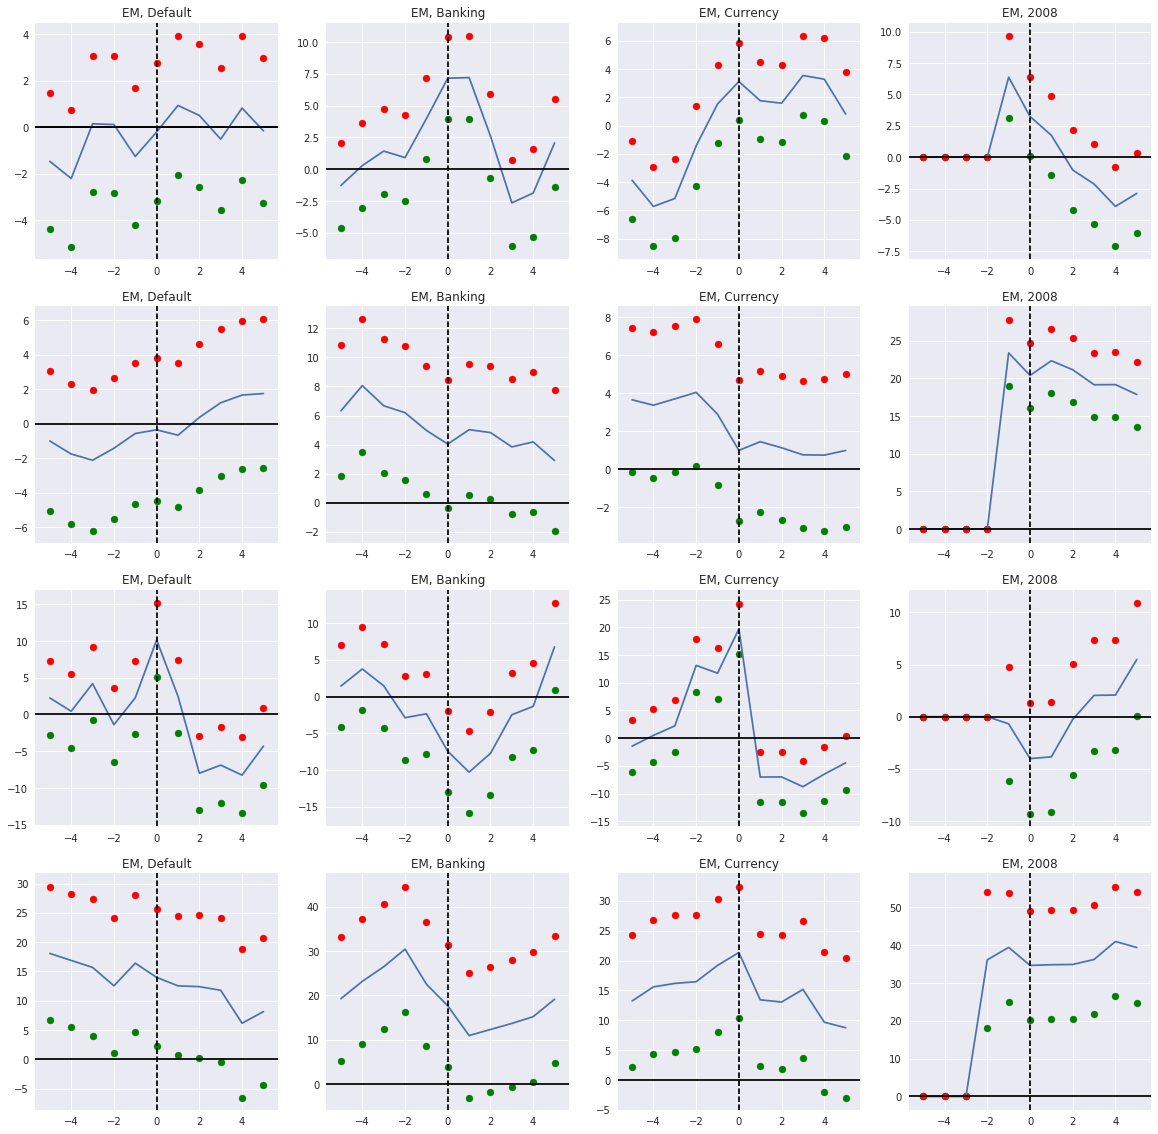

In [653]:
f, axarr = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))

#CreditGdp Plots
#EM, Default
ax1 = plt.subplot(4, 4, 1)
plt.axhline(y=0, color='black')
plt.plot(x_main, y_main_def_cr)
plt.scatter(x_main, y_lower_def_cr, color='green')
plt.scatter(x_main, y_upper_def_cr, color='red')
plt.title('EM, Default')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, Banking
plt.subplot(4, 4, 2)
plt.plot(x_main, y_main_bank_cr)
plt.scatter(x_main, y_lower_bank_cr, color='green')
plt.scatter(x_main, y_upper_bank_cr, color='red')
plt.title('EM, Banking')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, Currency
plt.subplot(4, 4, 3)
plt.plot(x_main, y_main_curr_cr)
plt.scatter(x_main, y_lower_curr_cr, color='green')
plt.scatter(x_main, y_upper_curr_cr, color='red')
plt.title('EM, Currency')
plt.axvline(x=0, color='black', linestyle='--')
#EM, 2008
plt.subplot(4, 4, 4)
plt.plot(x_main, y_main_2008_cr)
plt.scatter(x_main, y_lower_2008_cr, color='green')
plt.scatter(x_main, y_upper_2008_cr, color='red')
plt.title('EM, 2008')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')


#Reserves Plots
#EM, Default
plt.subplot(4, 4, 5)
plt.plot(x_main, y_main_def_res)
plt.scatter(x_main, y_lower_def_res, color='green')
plt.scatter(x_main, y_upper_def_res, color='red')
plt.title('EM, Default')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, Banking
plt.subplot(4, 4, 6)
plt.plot(x_main, y_main_bank_res)
plt.scatter(x_main, y_lower_bank_res, color='green')
plt.scatter(x_main, y_upper_bank_res, color='red')
plt.title('EM, Banking')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, Currency
plt.subplot(4, 4, 7)
plt.plot(x_main, y_main_curr_res)
plt.scatter(x_main, y_lower_curr_res, color='green')
plt.scatter(x_main, y_upper_curr_res, color='red')
plt.title('EM, Currency')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, 2008
plt.subplot(4, 4, 8)
plt.plot(x_main, y_main_2008_res)
plt.scatter(x_main, y_lower_2008_res, color='green')
plt.scatter(x_main, y_upper_2008_res, color='red')
plt.title('EM, 2008')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')

#Exchange Plots
#EM, Default
plt.subplot(4, 4, 9)
plt.plot(x_main, y_main_def_exc)
plt.scatter(x_main, y_lower_def_exc, color='green')
plt.scatter(x_main, y_upper_def_exc, color='red')
plt.title('EM, Default')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, Banking
plt.subplot(4, 4, 10)
plt.plot(x_main, y_main_bank_exc)
plt.scatter(x_main, y_lower_bank_exc, color='green')
plt.scatter(x_main, y_upper_bank_exc, color='red')
plt.title('EM, Banking')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, Currency
plt.subplot(4, 4, 11)
plt.plot(x_main, y_main_curr_exc)
plt.scatter(x_main, y_lower_curr_exc, color='green')
plt.scatter(x_main, y_upper_curr_exc, color='red')
plt.title('EM, Currency')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, 2008
plt.subplot(4, 4, 12)
plt.plot(x_main, y_main_2008_exc)
plt.scatter(x_main, y_lower_2008_exc, color='green')
plt.scatter(x_main, y_upper_2008_exc, color='red')
plt.title('EM, 2008')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')


#PublicDebt Plots
#EM, Default
plt.subplot(4, 4, 13)
plt.plot(x_main, y_main_def_pub)
plt.scatter(x_main, y_lower_def_pub, color='green')
plt.scatter(x_main, y_upper_def_pub, color='red')
plt.title('EM, Default')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, Banking
plt.subplot(4, 4, 14)
plt.plot(x_main, y_main_bank_pub)
plt.scatter(x_main, y_lower_bank_pub, color='green')
plt.scatter(x_main, y_upper_bank_pub, color='red')
plt.title('EM, Banking')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, Currency
plt.subplot(4, 4, 15)
plt.plot(x_main, y_main_curr_pub)
plt.scatter(x_main, y_lower_curr_pub, color='green')
plt.scatter(x_main, y_upper_curr_pub, color='red')
plt.title('EM, Currency')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')
#EM, 2008
plt.subplot(4, 4, 16)
plt.plot(x_main, y_main_2008_pub)
plt.scatter(x_main, y_lower_2008_pub, color='green')
plt.scatter(x_main, y_upper_2008_pub, color='red')
plt.title('EM, 2008')
plt.axvline(x=0, color='black', linestyle='--')
plt.axhline(y=0, color='black')

plt.show()

The estimates of conditional means of each variable, relative to ‘tranquil times’ are reported on the vertical axis. The horizontal axes represents the number of years before (negative sign) and after a crisis of a given type (in the different columns).

Estimates in each row are for (i) Ratio of domestic credit to output, (ii) The ratio of official reserves, (iii) The real exchange rate and (iv) The ratio of public debt to output, respectively from top to bottom. The dots denote a 95% confidence interval for each conditional mean.

# Extended Model

<a id="extended"></a>

Gourinchas and Obstfeld mentions the relationship between banking and currency crises, such that banking crises tend to begin ahead of currency crises. Starting from this point, we build our model to predict a currency crisis by using whether there has been a banking crisis in the last three years in addition to the statistically significant variables for currency crisis estimation model. We start by creating a new variable which indicates a banking crisis in the previous three years.

In [654]:
#Banking Crisis Dummies
df_eme['banklast3'] = (
    df_eme.bankvarL0 + df_eme.bankvarL1 + df_eme.bankvarL2 + df_eme.bankvarL3)

df_eme.loc[df_eme.banklast3 != 0, 'banklast3'] = '1'
df_eme.loc[df_eme.banklast3 == 0, 'banklast3'] = '0'

# Currency crisis occurence in the upcoming three years
df_eme['target'] = (
    df_eme.currcrisisvar3 + df_eme.currcrisisvar2 + df_eme.currcrisisvar1)


df_eme = df_eme.dropna(subset=['Credit/Gdp'])
df_eme = df_eme.dropna(subset=['CA/Gdp'])
df_eme = df_eme.dropna(subset=['Reserves/Gdp'])
df_eme = df_eme.dropna(subset=['ExchangeRate'])
df_eme = df_eme.dropna(subset=['PubDebt/Gdp'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

We calibrate the model by using train-test split. We include the banklast3 variable and the five variables which were statistically significant for currency crises in our logistic regression model in the first section as feauture columns. We split our data between train and test with a 0.8 to 0.2 ratio and fit the model accordingly.

In [655]:
#split dataset in features and target variable
feature_cols = ['Credit/Gdp', 'CA/Gdp', 'Reserves/Gdp', \
                'ExchangeRate', 'PubDebt/Gdp', 'banklast3']

x = df_eme[feature_cols] #Features
y = df_eme.target #Target

# Split x and y into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=0)

# Fit the model with data
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

# Predict
y_pred=logreg.predict(x_test)

In [656]:
# Create lists
column_labels = x.columns.tolist()
coef = logreg.coef_.squeeze().tolist()

# Zip together
labels_coef = list(zip(column_labels, coef))
print(labels_coef)

[('Credit/Gdp', 0.05043301392487006), ('CA/Gdp', -0.025151391700408293), ('Reserves/Gdp', -0.0920013371278995), ('ExchangeRate', -0.03669195305933695), ('PubDebt/Gdp', -0.002561193931391628), ('banklast3', -0.9876566271983804)]


## Model Evaluation

<a id="model_evaluation"></a>

We evaluate the performance of the model with the following metrics.

In [657]:
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)

print("The accuracy of the model is: " + str(round(Accuracy, 2)) + ".")
print("The precision of the model is: " + str(round(Precision, 2)) + ".")
print("The recall of the model is: " + str(round(Recall, 2)) + ".")

The accuracy of the model is: 0.81.
The precision of the model is: 0.67.
The recall of the model is: 0.1.


### Consufion Matrix

Next, we check the confusion matrix of the model:

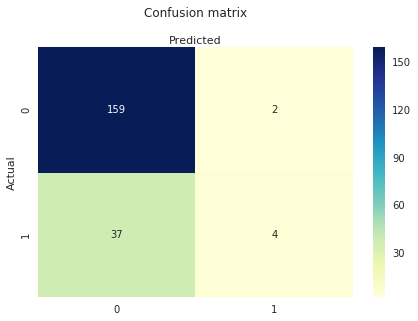

In [658]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### ROC Curve

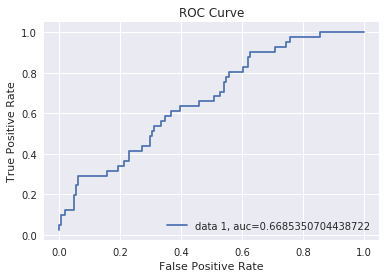

In [659]:
y_pred_proba = logreg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC graph shows a plausible degree of curve, however confusion matrix presents that the model predicted four of the crises in the upcoming three years correctly, while could not predict 37 of them. 

# Conclusions

<a id="conclusions"></a>

In this study, we replicated the Gourinchas and Obstfield (2011) paper, limited to the emerging market eceonomies. We used the covariates that the authors have used and obtained similar results with them. 
In the second part, we extended the study by developing a predictive analysis. However, model evaluation showed that our model did not predict any of the 11 crises. This shows that Gourinchas and Obstfield study is successful as a descriptive model but fails as a normative model. The low performing of the model can be due to relatively low occurance of the crises, hence difficult to predict only with the given indicators.
A future study can be done by expanding the parameters or using different criteria for feature selection into the model. We included banking crises as an additional parameter to estimate currency crises but found no significant effect for prediction. Further studies may also test other varieties of two-crises interaction with in different time windows.

# References

<a id="references"></a>

    Gourinchas, P., & Obstfeld, M. (2012). Stories of the twentieth century for the twenty-first. American Economic Journal: Macroeconomics, 4(1), 226-265. doi:10.1257/mac.4.1.226